# PLAsTiCC dataset

This notebook gives an example of Active Anomaly Detection with `coniferest` and [PLAsTiCC](https://plasticc.org/) dataset.

In [1]:
import numpy as np
from time import monotonic
from datetime import timedelta
import matplotlib.pyplot as plt

from coniferest.datasets import plasticc_gp

In [2]:
data, metadata = plasticc_gp()

In [3]:
from coniferest.isoforest import IsolationForest
from coniferest.aadforest import AADForest
from coniferest.pineforest import PineForest

In [4]:
models = {
    "Isolation Forest": IsolationForest,
    "AAD Forest": AADForest,
    "Pine Forest": PineForest,
}

In [5]:
from coniferest.session import oracle

In [6]:
max_iterations = 100
max_trials = 20

steps = np.arange(1, max_iterations + 1)

anomalies = {}
wall_times = {}
for name, model_class in models.items():

    wall_time = []
    anomalies_ = []
    for i in range(max_trials):
        session = oracle.create_oracle_session(data, metadata,
                                               model = model_class(random_seed = i),
                                               max_iterations = max_iterations)
    
        start_time = monotonic()
    
        session.run()
    
        wall_time.append(timedelta(seconds = monotonic() - start_time))
    
        labels = (1 - np.asarray(list(session.known_labels.values()), dtype=int)) // 2
        anomalies_.append(np.cumsum(labels) / steps)
    
    anomalies[name] = np.asarray(anomalies_)
    wall_times[name] = np.median(np.asarray(wall_time))

Text(0, 0.5, 'Fraction of anomalies')

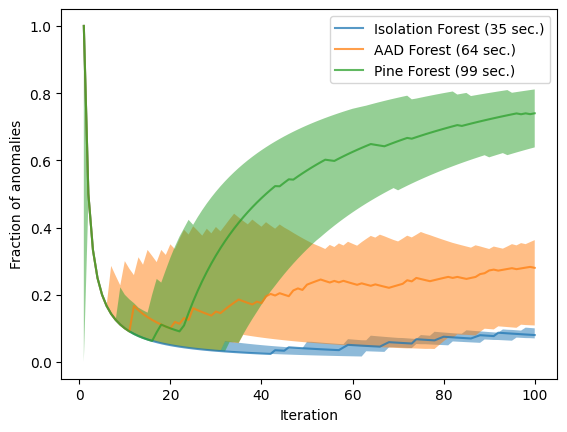

In [7]:
for name in models.keys():
    q5 = np.quantile(anomalies[name], 0.05, axis = 0)
    median = np.median(anomalies[name], axis = 0)
    q95 = np.quantile(anomalies[name], 0.95, axis = 0)
    
    plt.plot(steps, median,
             alpha=0.75,
             label="{} ({:.0f} sec.)".format(name, wall_times[name].total_seconds()))
    plt.fill_between(steps, q5, q95, alpha=0.5)

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Fraction of anomalies")